In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hlxon_hdf5io import *
from scipy.spatial.transform import Rotation
from filters.HelixonKalmanFilter import *
from metrics import *

In [2]:
def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2
    z = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2
    return np.array([w, x, y, z])

# Load data


In [3]:
# get data from hdf5
raw_timestamp, raw_9dof, raw_rpy, raw_bno, raw_bmp, raw_pressure, wifidata, gt_timestamp, gt_position, gt_orientation = readHDF5('RandomUDP3')

# p0 is first real pressure measurement
p0 = max(raw_pressure)

# convenience
X, Y, Z = 0, 1, 2
N = len(raw_timestamp)

# get sensor data
araw = np.array(raw_9dof[:, :3])
gyro = np.array(raw_9dof[:, 3:6])
magn = np.array(raw_9dof[:, 6:])
pres = np.array(raw_pressure).reshape((-1, 1))
alpha = 1.16e-4
ts = np.array(raw_timestamp)*1e-6
gt_timestamp = np.array(gt_timestamp)*1e-6


# Preprocess Data

In [4]:

rots = np.array([Rotation.from_quat(q).as_euler('xyz', degrees=True) for q in gt_orientation]) # change quat gt rots to euler
rots -= rots[0] # normalize to initial rot
rots = rots[:, ::-1] # reverse order of xyz to match ndof
rots[:, X] *= -1 # invert X rotations to match ndof
rots = np.array([Rotation.from_euler('xyz', r, degrees=True).as_euler('xyz', degrees=True) for r in rots])

# lerp rots
N = len(raw_rpy)

# interpolate over timestamps
lerped_rotations = np.zeros((N, 3))
for i in range(N):
    if ts[i] in gt_timestamp:
        lerped_rotations[i] = rots[np.argmax(gt_timestamp == ts[i])]
    else:
        # lerp
        ix_2 = np.argmax(gt_timestamp > ts[i])
        ix_1 = gt_timestamp.shape[0] - np.argmax(np.flip(gt_timestamp, axis=0) < ts[i]) - 1
        

        # lerp formula: y12 = y1 + (t12 - t1) * (y2-y1)/(t2-t1 + stability epsilon)
        lerped_rotations[i] = rots[ix_1] + (ts[i]-gt_timestamp[ix_1])*(rots[ix_2] - rots[ix_1])/(gt_timestamp[ix_2] - gt_timestamp[ix_1] + 1e-9)

rots = lerped_rotations

# Evaluate Performance

In [5]:
# Evaluate
print('-------------Shortest Angle Errors (norm of XYZ error)-------------')
# median angle error
ade = np.median(np.linalg.norm(abs(rots - raw_rpy)%180, axis=1))
print(f'angle median angle error: {ade}')

# average angle error
ade = np.mean(np.linalg.norm(abs(rots - raw_rpy)%180, axis=1))
print(f'angle average angle error: {ade}')

# max angle error
mde = np.linalg.norm(abs(rots - raw_rpy)%180, axis=1).max()
print(f'angle max angle error: {mde}')

# mean squared error over angles
msde = np.mean(np.linalg.norm(abs(rots - raw_rpy)%180, axis=1)**2)
print(f'angle mean squared angle error: {msde}')

print('-------------Individual Angle Component Errors-------------')
# median angle error
ade = np.median(np.abs(rots - raw_rpy)%180, axis=0)
print(f'angle median angle error: {ade}')

# average angle error
ade = np.mean(np.abs(rots - raw_rpy)%180, axis=0)
print(f'angle average angle error: {ade}')

# max angle error
mde = (np.abs(rots - raw_rpy)%180).max(axis=0)
print(f'angle max angle error: {mde}')

# mean squared error over angles
msde = np.mean((np.abs(rots - raw_rpy)%180)**2, axis=0)
print(f'angle mean squared angle error: {msde}')


-------------Shortest Angle Errors (norm of XYZ error)-------------
angle median angle error: 21.927458185619237
angle average angle error: 31.184485057678202
angle max angle error: 178.103362686248
angle mean squared angle error: 1928.9619560128945
-------------Individual Angle Component Errors-------------
angle median angle error: [21.60493974  1.91899602  1.87620355]
angle average angle error: [30.62918181  2.29794491  2.2513401 ]
angle max angle error: [178.06156205  11.32718344  11.75612826]
angle mean squared angle error: [1912.34701168    8.34389298    8.27105135]


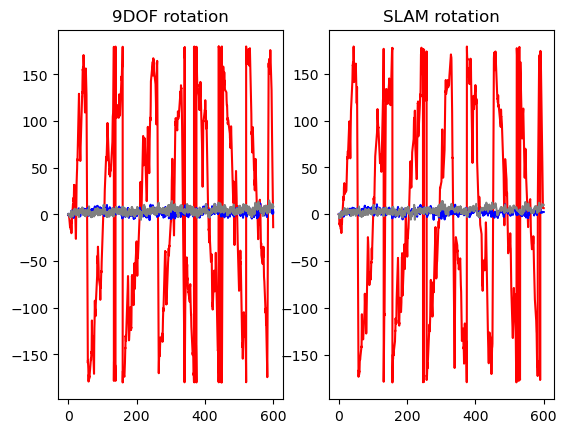

In [6]:

# plot positions as functions of time
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('9DOF rotation')
ax1.plot(raw_timestamp*1e-6, raw_rpy[:, X], color='red')
ax1.plot(raw_timestamp*1e-6, raw_rpy[:, Y], color='blue')
ax1.plot(raw_timestamp*1e-6, raw_rpy[:, Z], color='gray')

ax2.set_title('SLAM rotation')
ax2.plot(raw_timestamp*1e-6, rots[:, X], color='red')
ax2.plot(raw_timestamp*1e-6, rots[:, Y], color='blue')
ax2.plot(raw_timestamp*1e-6, rots[:, Z], color='gray')
plt.show()